<a href="https://colab.research.google.com/github/MiguelRochaBE/MotorImagery-BCI/blob/master/MI_BCI_DatasetAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Conexão ao Google Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


## **Extrair base de dados do ficheiro zip**

Link: https://physionet.org/content/eegmmidb/1.0.0/

In [ ]:
!unzip -u "/content/drive/MyDrive/B(i)onitos/files.zip" -d "/content/drive/MyDrive"

## **Listar todos os ficheiros da base de dados**

In [ ]:
import os

def run_fast_scandir(dir, ext):    # dir: str, ext: list
    subfolders, datafiles = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                datafiles.append(f.path)

    for dir in list(subfolders):
        sf, f = run_fast_scandir(dir, ext)
        subfolders.extend(sf)
        datafiles.extend(f)
    return subfolders, datafiles


subfolders, datafiles = run_fast_scandir('/content/drive/MyDrive/files', [".edf"])
#subfolders, eventfiles = run_fast_scandir('/content/drive/MyDrive/files', [".event"])

subfolders.sort()
datafiles.sort()
print(subfolders[:3])
print(datafiles[:3])


['/content/drive/MyDrive/files/S001', '/content/drive/MyDrive/files/S002', '/content/drive/MyDrive/files/S003']
['/content/drive/MyDrive/files/S001/S001R01.edf', '/content/drive/MyDrive/files/S001/S001R02.edf', '/content/drive/MyDrive/files/S001/S001R03.edf']


## **Biblioteca MNE: https://mne.tools/stable/index.html**


In [ ]:
!pip install mne
import mne

## **Ler dados e separar/agrupar os blocos de EEG consoante o tipo/classe de movimento**

In [ ]:
def load_subject_data(subject, datafiles):

  mne.set_log_level('WARNING') #  Suprimir os logs das funções da biblioteca

  '''
  Descrição dos eventos:

  Each annotation includes one of three codes (T0, T1, or T2):

    - T0 corresponds to rest
    - T1 corresponds to onset of motion (real or imagined) of the left fist (in runs 3, 4, 7, 8, 11, and 12)
                                                                    both fists (in runs 5, 6, 9, 10, 13, and 14)
    - T2 corresponds to onset of motion (real or imagined) of the right fist (in runs 3, 4, 7, 8, 11, and 12)
                                                                    both feet (in runs 5, 6, 9, 10, 13, and 14)
  '''

  trials=[] # Pré-alocação do array na memória
  for trial in datafiles: 
    if subject in trial: 
      trials.append(trial)
  
  print("Ficheiros a ler: ", trials)
  
  all_trials = [] # Variável com todos os blocos
  
  rest_events = 0 # Variáveis para contagem de eventos
  left_fist_events = 0
  right_fist_events = 0
  both_fists_events = 0
  both_feet_events = 0

  for count, trial  in enumerate(trials):
    if count > 1: # Avança os dois primeiros trials correspondentes ao rest
      data = mne.io.read_raw_edf(trial, preload = True) # Dados EEG para um trial específico. 'Preload=True' serve para colocar o ficheiro na memória e não apenas referenciá-lo no diretório

      ch_names = data.ch_names # Elétrodos
      fs =  data.info.get('sfreq') # Frequência de amostragem
      annotations = data.annotations # Variável que contém os dados no tempo relativos aos blocos de movimentos executados
      
      trial_type1 = [3, 4, 7, 8, 11, 12]
      trial_type2 = [5, 6, 9, 10, 13, 14]

      # Atribuição das labels corretas aos eventos de cada trial

      trial_number = int(trial.split('.')[0][-2:]) # De 1 a 14; [0] corresponde à primeira parte da string original;
      print("Trial lido: ",trial_number)
      if trial_number in trial_type1:
        event_ids = {'T0': 1, 'T1': 2, 'T2': 3} # Dicionário com os ids dos eventos de acordo com a descrição a laranja ^^
        epoch_event_ids = {"rest/block": 1, "left_fist/block": 2, "right_fist/block": 3}
      elif trial_number in trial_type2:
        event_ids = {'T0': 1, 'T1': 4, 'T2': 5}
        epoch_event_ids = {"rest/block": 1, "both_fists/block": 4,"both_feet/block": 5}
      else:
        event_ids = {'T0': 1} # Dois primeiros trials de EEG

      events = mne.events_from_annotations(data, event_id = event_ids) # Variável eventos: Retorna 3 colunas [Indice da amostra onde começa o bloco, Trigger, Tipo de movimento (label)]
      
      # Agrupamento dos blocos do mesmo id (epoching)

      epochs = mne.Epochs(data, events[0], event_id = epoch_event_ids, baseline = None, preload = True)
      
      #Contagem to tipo de eventos para verificar se há perda de informação durante a concatenação

      rest_events += epochs["rest"].__len__()
      if trial_number in trial_type1:
        left_fist_events += epochs["left_fist"].__len__()
        right_fist_events += epochs["right_fist"].__len__()
      else:
        both_fists_events += epochs["both_fists"].__len__()
        both_feet_events += epochs["both_feet"].__len__()

      if count == len(trials)-1:
        print("------------------------- Dados do último ficheiro lido -------------------------")
        print("\nInfo dos dados: ", data.info)
        print("\nElétrodos: ", ch_names)
        print("\nAnotações: ", annotations.description)
        print("\nEventos: ", events)
        print("\nInformação dos blocos: ", epochs.info)
        print("\n")

        figure = mne.viz.plot_events(events[0]) # Gráfico dos eventos
        print("\n")
        data.plot(events=events[0]) # Plot dos dados com a speraração dos eventos

      all_trials.append(epochs)

  print("\nPré-concatenção de eventos: ")
  print("Número total de eventos: ", rest_events + left_fist_events + right_fist_events + both_fists_events + both_feet_events)
  print(f"Rest: {rest_events} -- Right Fist: {left_fist_events} -- Left Fist: {right_fist_events} -- Both Fists: {both_fists_events} -- Both Feet: {both_feet_events}")

  # Concatenação de todos os blocos

  subject_epochs = mne.concatenate_epochs(all_trials, add_offset = True, on_mismatch = 'raise')

  print("\nPós-concatenação de eventos: ")
  print("Número total de eventos: ", subject_epochs.__len__())
  print("Rest: ", subject_epochs["rest"].__len__())
  print("Right Fist: ", subject_epochs["right_fist"].__len__())
  print("Left Fist: ", subject_epochs["left_fist"].__len__())
  print("Both Fists: ", subject_epochs["both_fists"].__len__())
  print("Both Feet: ", subject_epochs["both_feet"].__len__())
  print("\n")
  
  return subject_epochs

subject_epochs = load_subject_data(subfolders[10],datafiles)


In [ ]:
dir(subject_epochs)

In [ ]:
print("Condições: ",subject_epochs.event_id)
print("\nBlocos: ",subject_epochs.events)
subject_epochs["right_fist"].plot_image(picks=[8])

In [ ]:
dt = subject_epochs.to_data_frame()
print(dt.columns)
print("\n",dt)

## **Mapa dos elétrodos da base de dados:**

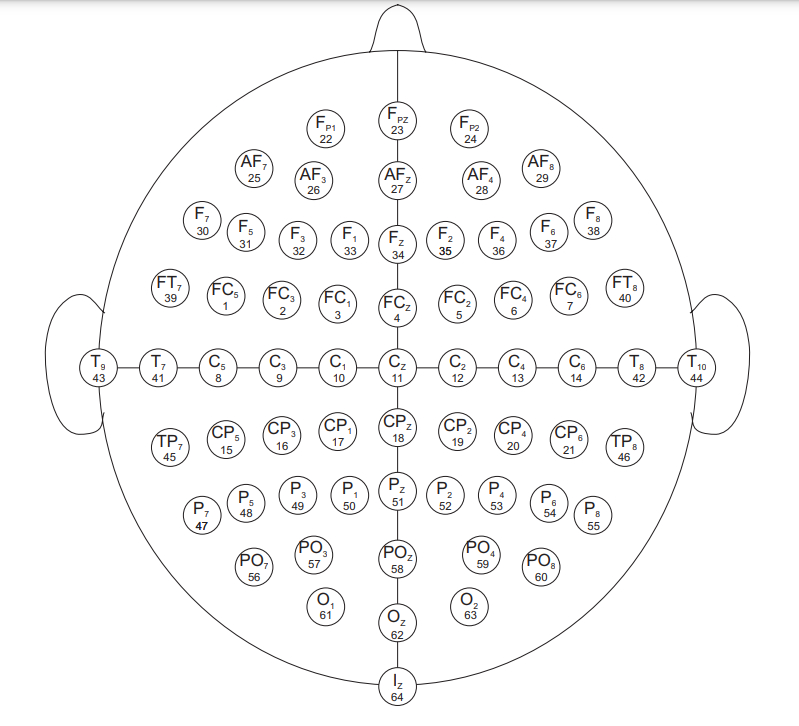